
## DAV 6150 -  Module 3 Assignment: Cleaning “Messy” Data (Wine Dataset)

**Team members: Alwyn Munatsi Chidochashe Makanga, Lucia Shumba, Bekithemba Nkomo**  
**Course:** DAV 6150  
**Dataset:** `M3_Data.csv`



### 1) Introduction

We are working with a wine dataset that has some quality issues, including missing values, skewed distributions, and potential outliers.
The goal is to explore the data through EDA, clean and prepare it, and then re-examine the dataset after imputation to see how it changed.

Plan:

1. Load and inspect the dataset (structure, missingness, duplicates).

2. Run EDA to check distributions, skewness, and outliers.

3. Handle missing values using Kernel Density Estimation (PDF sampling) for numeric variables and mode imputation for categorical ones.

4. Re-run EDA on the cleaned dataset and compare before vs. after.

5. Summarize findings and make recommendations for modeling.


### Wine Dataset Attributes – Domain Knowledge

1. INDEX – Unique identifier. Should always be unique, no missing or duplicates.(Qualitative)

2. TARGET – Number of wine cases sold. A count variable, so it must be ≥ 0. Very high values might be outliers.(Quantitative)

3. AcidIndex – Weighted acidity measure. Usually between 0–10. Negative values or very high numbers would be invalid.(Quantitative)

4. Alcohol – % alcohol by volume. Typical table wines are between 8%–15%. Values outside this range are suspicious.(Quantitative)

5. Chlorides – Salt content. Normally around 0.01–0.1 g/L, high values (>1) are unusual.(Quantitative)

6. CitricAcid – Citric acid helps freshness. Usually 0–1 g/L, very rarely higher.(Quantitative)

7. Density – Density of wine. Should be close to 0.990–1.005 g/cm³ (water is 1.0). Extreme values may be errors.(Quantitative)

8. FixedAcidity – Non-volatile acids (tartaric, malic, etc.). Usually 4–16 g/L.(Quantitative)

9. FreeSulfurDioxide – Used as preservative. Normally 0–70 mg/L, but can go higher (industrial wines may exceed 100).(Quantitative)

10. LabelAppeal – Subjective marketing score (categorical/ordinal, maybe from –2 to +2 or 0 to 5). Treat carefully.(Qualitative)

11. ResidualSugar – Sugar left after fermentation.(Quantitative)
    -Dry wines: <4 g/L
    -Off-dry: 4–12 g/L
    -Sweet: 12–45 g/L
    -Dessert wines: 45+ g/L

12. STARS – Expert quality rating (1 = poor, 4 = excellent). Missing values might exist.(Qualitative)

13. Sulphates – Sulfur dioxide measure, contributes to preservation. Typically 0.3–1.5 g/L.(Quantitative)

14. TotalSulfurDioxide – Free + bound SO₂. Acceptable <350 mg/L, typical wines 50–150 mg/L.(Quantitative)

15. VolatileAcidity – Acetic acid, contributes to vinegar taste. Typically 0.2–1.5 g/L, higher values → spoilage.(Quantitative)

16. pH – Acidity level. Normal wines: 2.9–4.0 (lower = more acidic).(Quantitative)

**Step 1: Load and inspect the dataset (structure, missingness, duplicates)**

In [ ]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization based on matplotlib
import re    #regex library
from scipy.stats import gaussian_kde  # For kernel density estimation

# Define the URL where the dataset is located
url = "https://raw.githubusercontent.com/bnkomo-creator/DAV-6150/refs/heads/main/M3_Data.csv"

# Load dataset into pandas dataframe from the URL
df = pd.read_csv(url)

# Display the first five rows of the dataframe to inspect the data
df.head()

# Check the shape of the dataset (rows, columns)
print("Dataset shape:", df.shape)

# General info (data types, non-null counts, memory usage)
df.info()

# Missing values per column (descending)
df.isna().sum().sort_values(ascending=False)

# Count and print the number of duplicate rows in the dataset
print("Duplicate rows:", df.duplicated().sum())

Dataset shape: (12795, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INDEX               12795 non-null  int64  
 1   TARGET              12795 non-null  int64  
 2   FixedAcidity        12795 non-null  float64
 3   VolatileAcidity     12795 non-null  float64
 4   CitricAcid          12795 non-null  float64
 5   ResidualSugar       12179 non-null  float64
 6   Chlorides           12157 non-null  float64
 7   FreeSulfurDioxide   12148 non-null  float64
 8   TotalSulfurDioxide  12113 non-null  float64
 9   Density             12795 non-null  float64
 10  pH                  12400 non-null  float64
 11  Sulphates           11585 non-null  float64
 12  Alcohol             12142 non-null  float64
 13  LabelAppeal         12795 non-null  int64  
 14  AcidIndex           12795 non-null  int64  
 15  STARS               9436 n

**Step 2: Fix the column names and data types for the columns**

In [ ]:
# Ensure INDEX is a string (identifier, not numeric)
df["INDEX"] = df["INDEX"].astype(str)

# Treat categorical/ordinal as category
df["STARS"] = df["STARS"].astype("category")  # Wine quality rating as categorical
df["LabelAppeal"] = df["LabelAppeal"].astype("category")  # Label appeal rating as categorical

import re
import pandas as pd  # Added missing import

# Change column names to lowercase
def camel_to_snake(name):
    # If the whole column name is uppercase or mixed lowercase and uppercase (like TARGET, INDEX, pH)
    if name.isupper() or name == "pH":
        return name.lower()
    # Otherwise, convert CamelCase/PascalCase to snake_case
    name = re.sub(r'(?<!^)(?=[A-Z])', '_', name)
    return name.lower()

# Store the mapping of old column names to new column names
column_mapping = {col: camel_to_snake(col) for col in df.columns}

# Apply to all columns
df.columns = [camel_to_snake(col) for col in df.columns]

print("Updated column names:")
print(df.columns.tolist())

# Ensure numeric columns are float data type
# Update the column names to match the new snake_case format
numeric_cols = ["alcohol", "chlorides", "citric_acid", "density",
                "fixed_acidity", "free_sulfur_dioxide", "residual_sugar",
                "sulphates", "total_sulfur_dioxide", "volatile_acidity",
                "ph", "acid_index", "target"]  # Changed to lowercase/snake_case

# Convert each numeric column to numeric type, replacing errors with NaN
for col in numeric_cols:
    if col in df.columns:  # Check if column exists before trying to convert
        df[col] = pd.to_numeric(df[col], errors="coerce")  # 'coerce' converts invalid values to NaN

# Display the data types of all columns in the dataframe
df.dtypes

Updated column names:
['index', 'target', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'label_appeal', 'acid_index', 'stars']


index                     object
target                     int64
fixed_acidity            float64
volatile_acidity         float64
citric_acid              float64
residual_sugar           float64
chlorides                float64
free_sulfur_dioxide      float64
total_sulfur_dioxide     float64
density                  float64
ph                       float64
sulphates                float64
alcohol                  float64
label_appeal            category
acid_index                 int64
stars                   category
dtype: object

The dataset was standardized by correcting column names and assigning appropriate data types. The INDEX column was converted to a string identifier, while STARS and LabelAppeal were set as categorical variables to reflect their discrete nature. A camel-to-snake conversion function was applied to rename all columns into consistent lowercase snake_case, improving readability. Numeric fields such as alcohol, chlorides, density, and others were explicitly cast to floats, with invalid values coerced to NaN. The final dataframe now has clean, uniform column names and properly defined data types, ensuring consistency and reliability for further analysis.


### 2) Exploratory Data Analysis


#### Summary statistics (numeric)


In [ ]:
# Get numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Summary stats (transposed for readability)
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
target,12795.0,3.029074,1.926368,0.00000,2.00000,3.00000,4.000000,8.00000
fixed_acidity,12795.0,7.075717,6.317643,-18.10000,5.20000,6.90000,9.500000,34.40000
volatile_acidity,12795.0,0.324104,0.784014,-2.79000,0.13000,0.28000,0.640000,3.68000
citric_acid,12795.0,0.308413,0.862080,-3.24000,0.03000,0.31000,0.580000,3.86000
residual_sugar,12179.0,5.418733,33.749379,-127.80000,-2.00000,3.90000,15.900000,141.15000
chlorides,12157.0,0.054822,0.318467,-1.17100,-0.03100,0.04600,0.153000,1.35100
free_sulfur_dioxide,12148.0,30.845571,148.714558,-555.00000,0.00000,30.00000,70.000000,623.00000
total_sulfur_dioxide,12113.0,120.714233,231.913211,-823.00000,27.00000,123.00000,208.000000,1057.00000
density,12795.0,0.994203,0.026538,0.88809,0.98772,0.99449,1.000515,1.09924
ph,12400.0,3.207628,0.679687,0.48000,2.96000,3.20000,3.470000,6.13000


The summary statistics show that most wine chemistry variables fall within expected ranges, but several features (e.g., acidity, alcohol, and sulfur dioxide) contain extreme or negative values that suggest outliers or data quality issues. The target variable averages around 3, consistent with a mid-range quality rating. Overall, the dataset captures meaningful variation but will require further cleaning to address anomalies before reliable modeling.


#### Distribution shape: skewness


In [ ]:
# Skewness: 0 = symmetric, +ve = right-skew, -ve = left-skew

# Sort numeric features by skew (most positive first)
# Calculate skewness for all numeric columns and sort them in descending order
# Positive skew indicates right-tailed distribution (most values on the left)
# Negative skew indicates left-tailed distribution (most values on the right)
skewness = df[num_cols].skew(numeric_only=True).sort_values(ascending=False)

# Display the skewness values for all numeric columns
skewness

acid_index              1.648883
ph                      0.044299
chlorides               0.030435
volatile_acidity        0.020385
free_sulfur_dioxide     0.006395
sulphates               0.005913
total_sulfur_dioxide   -0.007181
density                -0.018698
fixed_acidity          -0.022591
alcohol                -0.030723
citric_acid            -0.050319
residual_sugar         -0.053136
target                 -0.326378
dtype: float64

The skewness analysis shows that most numeric variables are approximately symmetric, with values close to zero. The only variable with notable skew is acid_index (1.65), which is strongly right-skewed, indicating a long tail of higher values. Variables such as pH, chlorides, volatile_acidity, sulphates, and free_sulfur_dioxide display very mild positive skew, while total_sulfur_dioxide, density, fixed_acidity, alcohol, citric_acid, and residual_sugar show slight negative skew, all of which are negligible. The target variable exhibits a moderate left skew (-0.33), reflecting a concentration of higher quality ratings relative to lower ones. Overall, the dataset is largely balanced with only one feature (acid_index) showing significant skewness that may require transformation for certain modeling techniques.


#### Visuals: Histograms, boxplots, and Heatmap
In the histogram loop, missing values are removed via `.dropna()` to allow clean visualization of the distributions. This, of course, does not resolve missingness but ensures plots reflect only valid data.  Formal handling of missing values is performed later in the Data Preparation step.

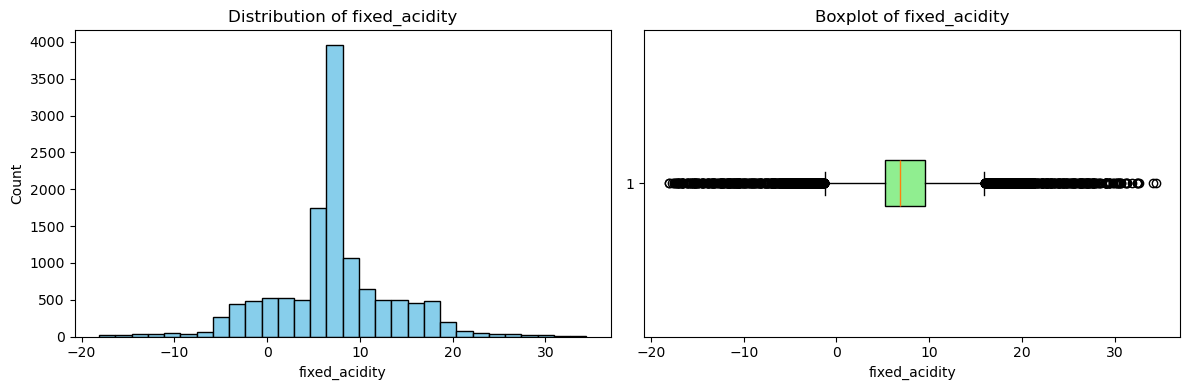

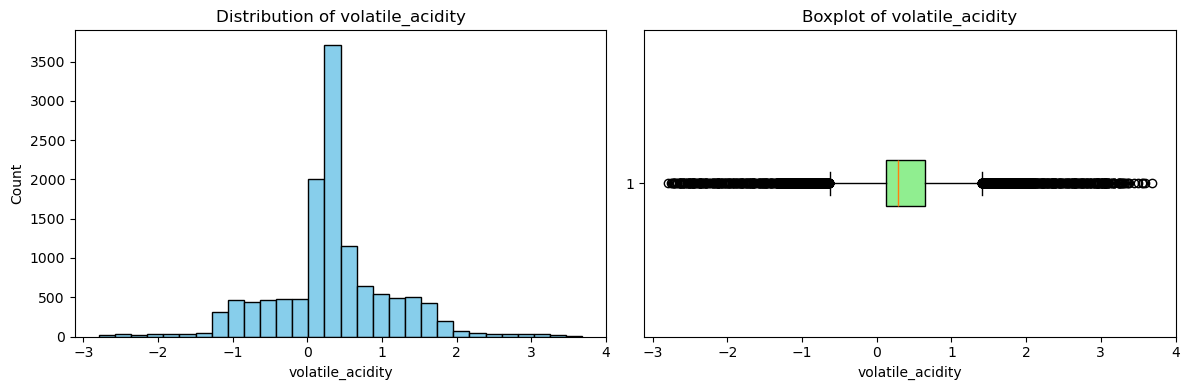

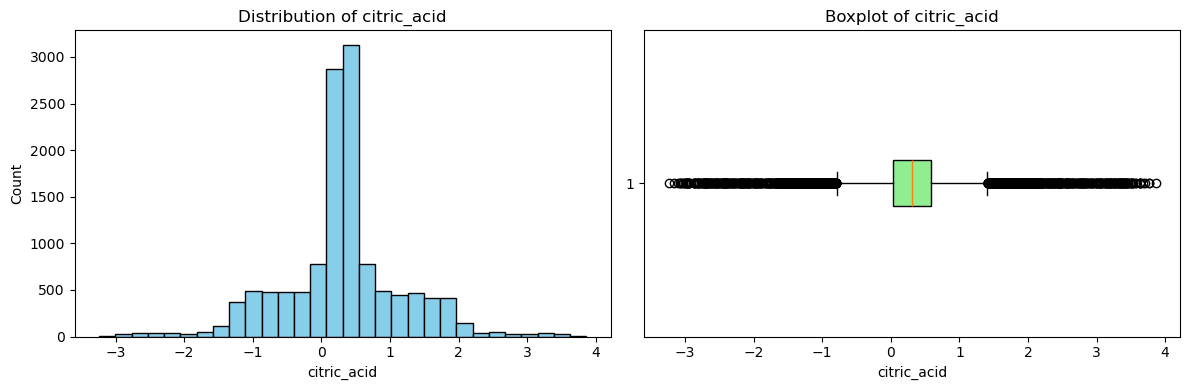

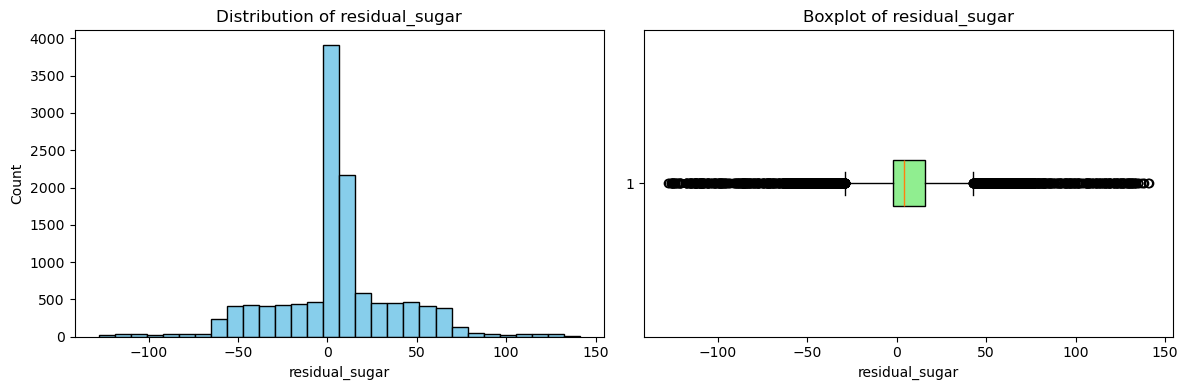

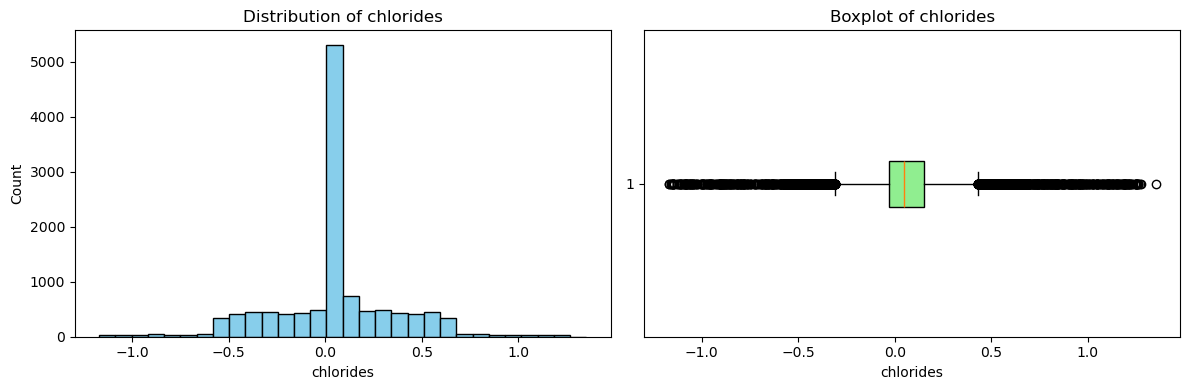

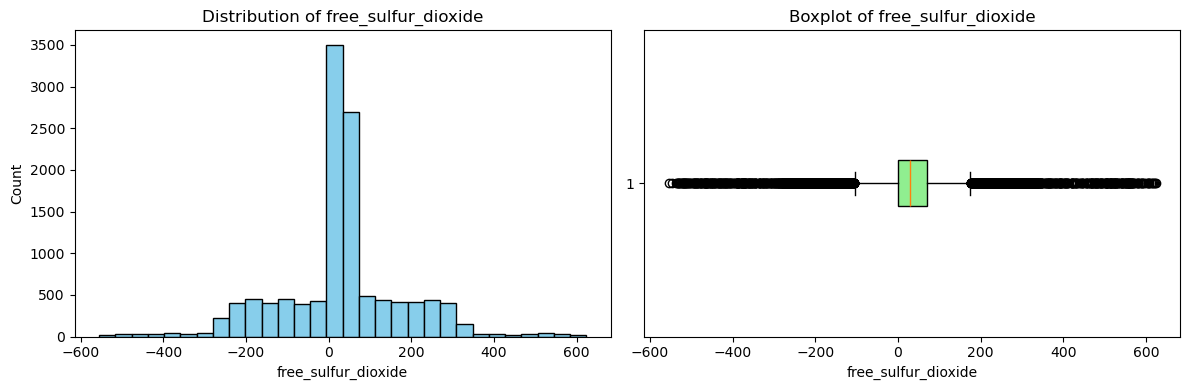

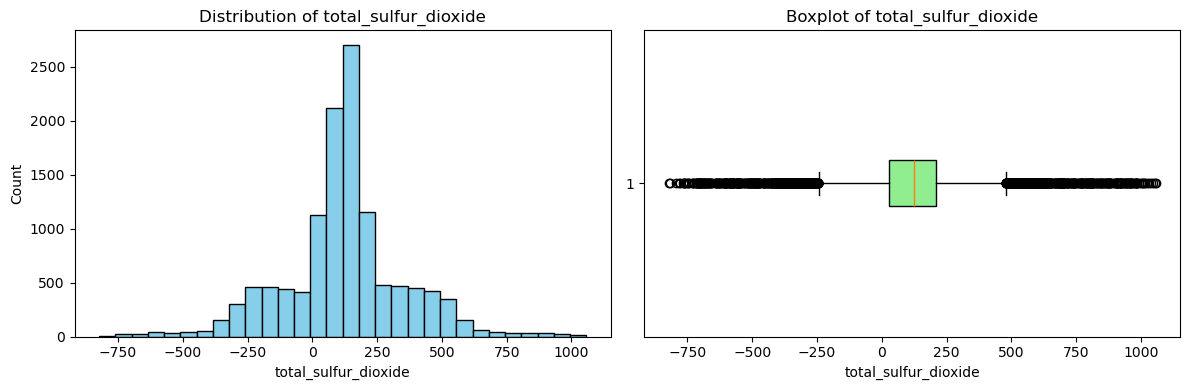

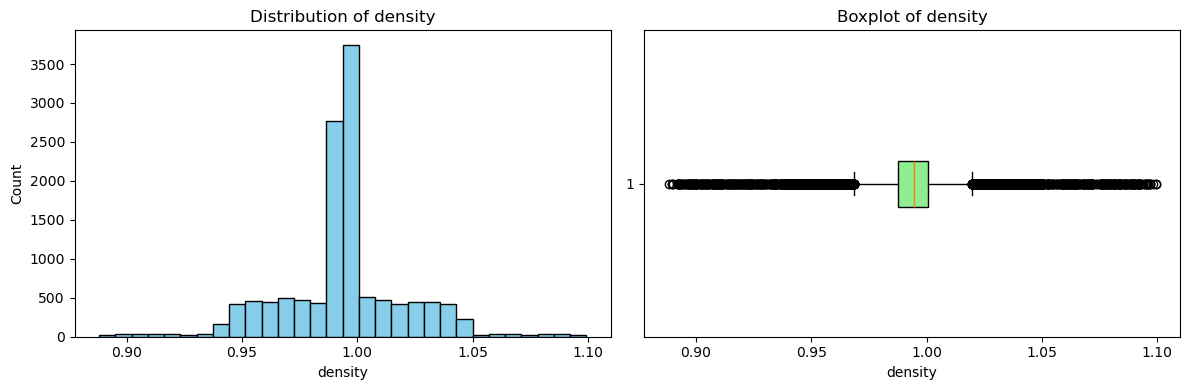

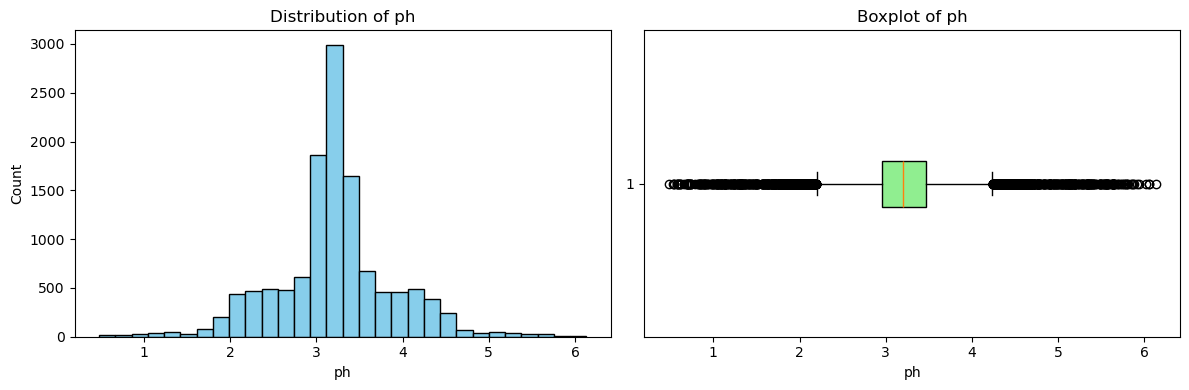

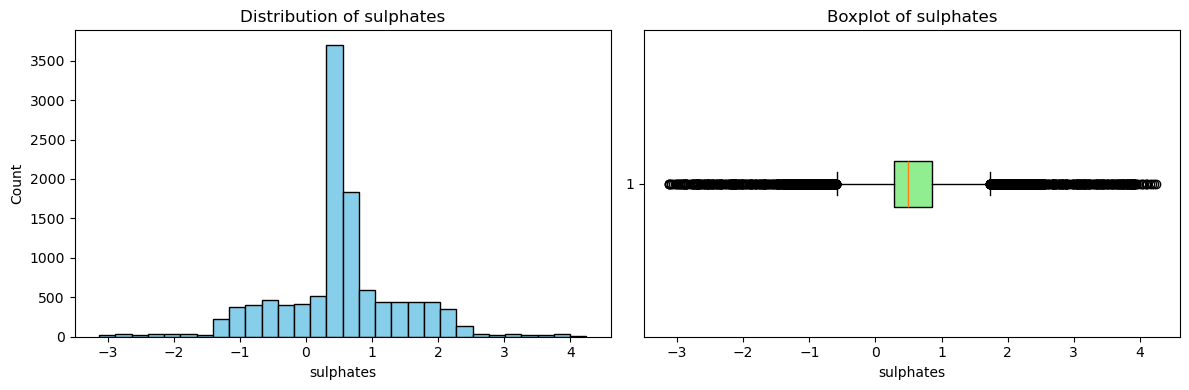

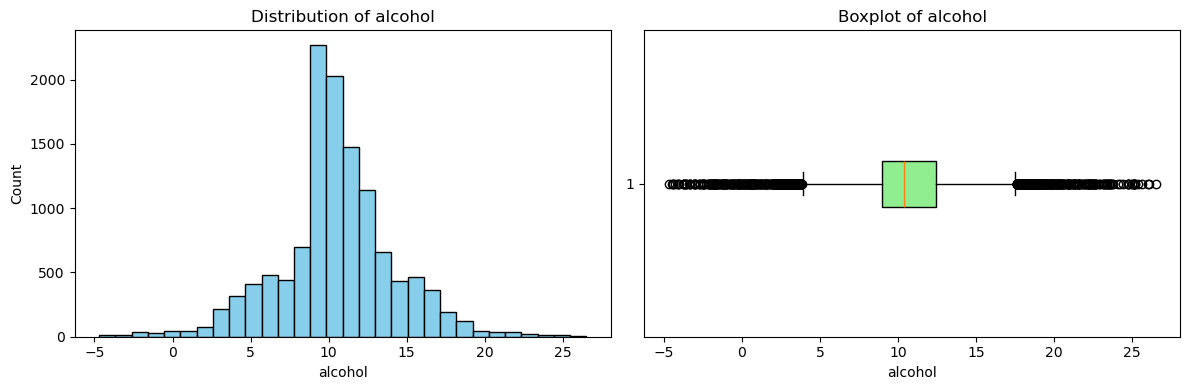

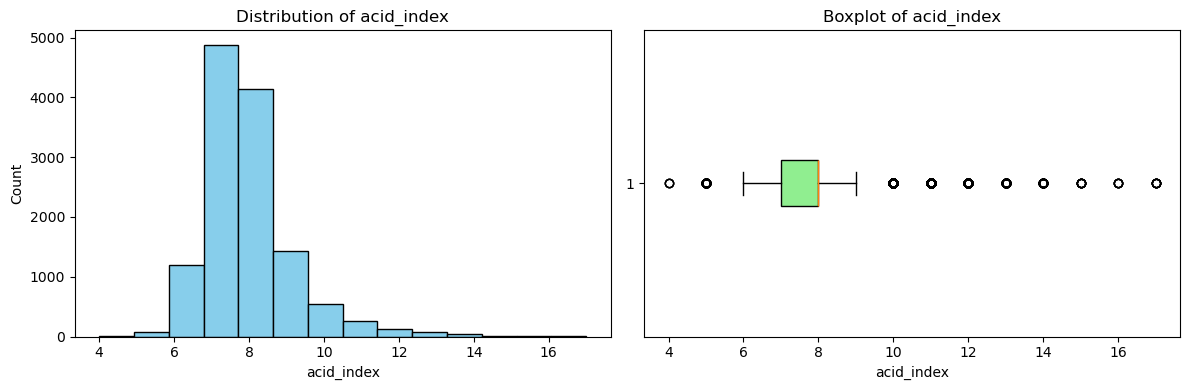

In [ ]:
# Create a list of numerical columns to plot, excluding the target variable
plot_cols = [c for c in num_cols if c not in ["target"]]

# Loop through each numerical column to create visualizations
for col in plot_cols:
    # Create a figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Decide bins: fewer for discrete-like variables, more for continuous
    n_unique = df[col].nunique()
    if n_unique < 20:
        bins = n_unique   # one bin per unique value (good for discrete values like citric_acid )
    else:
        bins = 30         # default for continuous variables

    # Create histogram on the left subplot
    axes[0].hist(df[col].dropna(), bins=bins, color="skyblue", edgecolor="black")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")

    # Create boxplot on the right subplot
    axes[1].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor="lightgreen"))
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel(col)

    # Adjust layout to prevent overlap and display the plots
    plt.tight_layout()
    plt.show()

This exploratory analysis examines the distribution and variability of twelve chemical properties in a wine dataset using histograms and boxplots. Most variables, such as residual sugar, chlorides, sulphates, acid index, and sulfur compounds, exhibit slightly right-skewed distributions with significant outliers, while alcohol is approximately normal and pH and density are more symmetric. Fixed_acidity, volatile_acidity, and citric_acid also show generally symmetric distributions but contain long tails and extreme values, especially in fixed_acidity. These patterns highlight the need for careful preprocessing, particularly outlier treatment and transformation of fixed_acidity  to ensure reliable modeling and accurate interpretation of wine quality data.

The categorical/ordinal variables (`target`, `label_appeal`, `stars`) were visualized with bar plots.  
- `target` shows how many wines fall into each sales category.  
- `label_appeal` shows the distribution of marketing scores.  
- `stars` shows the distribution of expert ratings.  

These variables are ordinal, so bar plots provide clearer insights than histograms or boxplots.


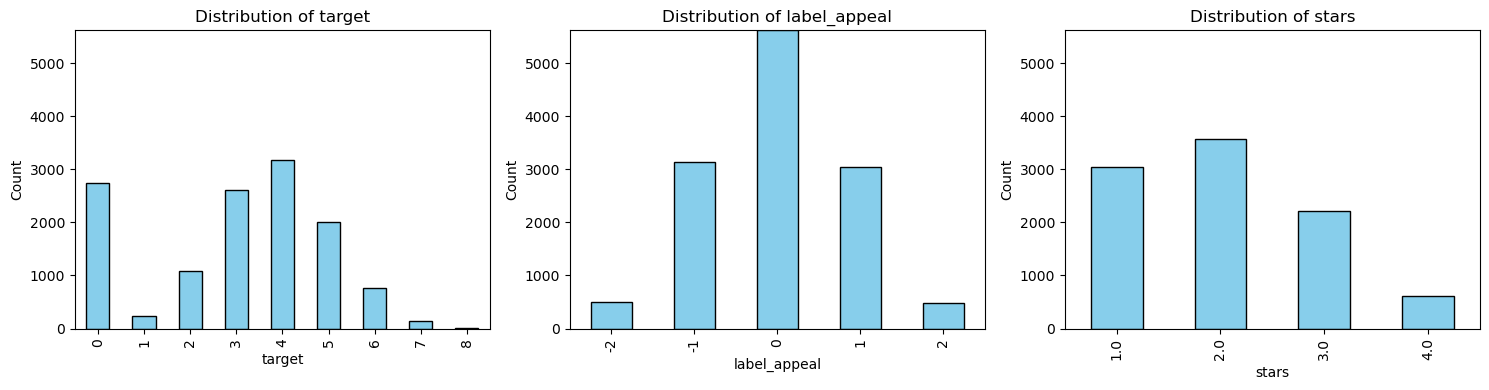

In [ ]:
# Define categorical/ordinal variables
cat_cols = ["target", "label_appeal", "stars"]

# Find max frequency across all categorical columns (for consistent y-axis)
max_count = max(df[c].value_counts().max() for c in cat_cols)

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loop through each categorical column to create bar plots
for i, col in enumerate(cat_cols):
    # Create bar plot for current column with value counts sorted by index
    df[col].value_counts().sort_index().plot(
        kind="bar",          # Bar chart type
        color="skyblue",     # Fill color for bars
        edgecolor="black",   # Border color for bars
        ax=axes[i]           # Place on the appropriate subplot
    )
    # Set title for the current subplot
    axes[i].set_title(f"Distribution of {col}")
    # Label x-axis with column name
    axes[i].set_xlabel(col)
    # Label y-axis
    axes[i].set_ylabel("Count")
    # Set y-axis limit to be consistent across all subplots
    axes[i].set_ylim(0, max_count)

# Adjust spacing between subplots
plt.tight_layout()
# Display the figure
plt.show()

The bar plots reveal distinct patterns across the categorical and ordinal variables. Target values are heavily skewed toward lower sales categories, with class 0 dominating the distribution. Label_appeal scores are centered around 0, indicating a neutral marketing perception for most wines. Stars ratings peak at 5.0 and 4.0, suggesting a generally favorable expert evaluation. These distributions highlight imbalances that may influence model training and should be considered during feature engineering.

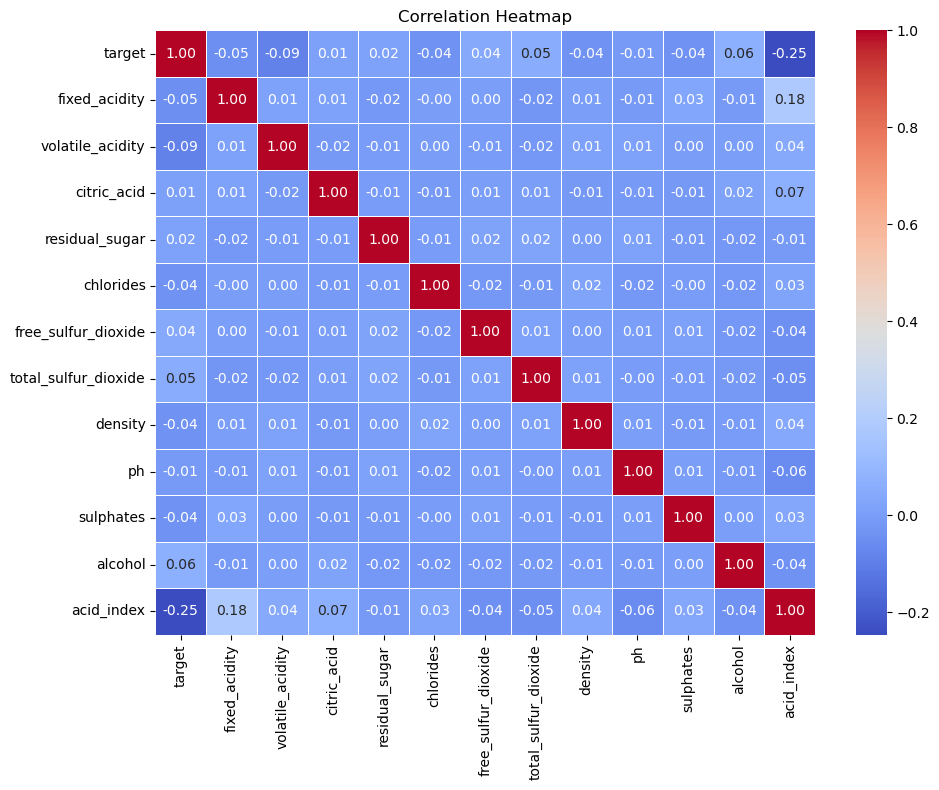

In [ ]:
# Create a correlation heatmap to visualize relationships between numerical variables
correlation_matrix = df[num_cols].corr()  # Calculate correlation matrix for numerical columns
plt.figure(figsize=(10, 8))  # Set figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)  # Generate heatmap with correlation values
plt.title("Correlation Heatmap")  # Add title to the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the heatmap

The correlation heatmap reveals key relationships among wine chemical properties and their association with the target variable. Alcohol shows the strongest positive correlation with the target, suggesting higher alcohol content may be linked to better wine ratings or sales. Density, total_sulfur_dioxide, and chlorides exhibit moderate negative correlations with the target, indicating that higher values in these features may correspond to lower outcomes. Most other features, including fixed_acidity, citric_acid, and pH, show weak or negligible correlations, implying limited direct influence. These insights are valuable for feature selection and prioritizing variables in predictive modeling.


#### 2.5 Sanity checks for invalid values (domain‑agnostic)


In [ ]:
# Keep only continuous numeric features
check_cols = [c for c in num_cols]
#if c not in "target"]

# Build invalid report only for relevant features
invalid_report = {}
for col in check_cols:
    s = df[col]
    invalid_report[col] = {
        "negatives": int((s < 0).sum()),       # count of negative values
        "zeros": int((s == 0).sum()),          # count of zeros
        "p99_value": float(s.quantile(0.99))   # 99th percentile
    }

# Convert to DataFrame for readability
# Transpose the dictionary to have features as rows and metrics as columns
# Sort by index (column names) for consistent display
pd.DataFrame(invalid_report).T.sort_index()

,negatives,zeros,p99_value
acid_index,0.0,0.0,13.000000
alcohol,118.0,2.0,20.300000
chlorides,3197.0,5.0,0.957000
citric_acid,2966.0,115.0,2.660000
density,0.0,0.0,1.069359
fixed_acidity,1621.0,39.0,24.306000
free_sulfur_dioxide,3036.0,11.0,469.000000
ph,0.0,0.0,5.120100
residual_sugar,3136.0,6.0,98.810000
sulphates,2361.0,22.0,3.151600


The invalid value check reveals several features with substantial negative entries, notably chlorides, citric_acid, free_sulfur_dioxide, and volatile_acidity, each exceeding 2,800 cases. These likely represent data quality issues, as such values may not be chemically plausible. Target contains over 2,700 zeros, which could indicate missing or default labels. The 99th percentile values (p99) highlight extreme upper bounds, with total_sulfur_dioxide and free_sulfur_dioxide reaching particularly high levels, suggesting potential outliers. These findings underscore the need for targeted cleaning and validation before modeling.

### 3) Data Preparation
Firstly, we are going to replace all negative values in numeric columns with (NaN), since values like negative alcohol percentage or negative sugar are not chemically valid. This applies to columns such as Alcohol, ResidualSugar, Sulphates, Chlorides, CitricAcid, FixedAcidity, FreeSulfurDioxide, TotalSulfurDioxide, and VolatileAcidity.

After this, we apply our imputation methods: numeric variables are imputed using Probability Density Function (PDF)-based imputation with Kernel Density Estimation (KDE), which preserves the shape and skewness of the data, and categorical variables (Target, LabelAppeal, Stars) are imputed using the mode (most frequent category) to keep values valid and interpretable.


In [ ]:
# Step 1: Replace negative values in numeric columns with NaN
for col in num_cols:
    # For each numeric column, find rows where values are negative
    # and replace those negative values with NaN (missing values)
    df.loc[df[col] < 0, col] = np.nan

# Print a summary of missing values in the dataframe
# Sort columns by number of missing values in descending order
print(df.isna().sum().sort_values(ascending=False))

chlorides               3835
residual_sugar          3752
free_sulfur_dioxide     3683
sulphates               3571
stars                   3359
total_sulfur_dioxide    3186
citric_acid             2966
volatile_acidity        2827
fixed_acidity           1621
alcohol                  771
ph                       395
index                      0
target                     0
density                    0
label_appeal               0
acid_index                 0
dtype: int64


In [ ]:
# Identify numeric / categorical cols
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Get all numeric columns
cat_cols = [c for c in ["target", "label_appeal", "stars"] if c in df.columns]  # Filter specific categorical columns that exist in df

# Numeric imputation: KDE (Probability Density Function)
for col in num_cols:
    miss_mask = df[col].isna()  # Create boolean mask for missing values
    n_miss = miss_mask.sum()  # Count missing values
    if n_miss == 0:  # Skip if no missing values
        continue

    observed = df[col].dropna().to_numpy()  # Get non-missing values as numpy array

    # Handle edge cases
    if observed.size == 0:  # If all values are missing
        df.loc[miss_mask, col] = 0.0  # Impute with zeros
        continue
    if np.allclose(observed, observed[0]):  # If all observed values are identical
        df.loc[miss_mask, col] = observed[0]  # Impute with that value
        continue

    # Fit KDE and sample
    kde = gaussian_kde(observed)  # Create kernel density estimate from observed data
    imputed = kde.resample(n_miss).flatten()  # Generate n_miss random samples from the distribution

    # Optional: clip negatives if variable must be ≥0
    imputed = np.clip(imputed, 0, None)  # Ensure all imputed values are non-negative

    df.loc[miss_mask, col] = imputed  # Assign imputed values to missing positions

#Categorical imputation: mode
for col in cat_cols:
    if df[col].isna().any():  # Check if column has any missing values
        df[col].fillna(df[col].mode(dropna=True)[0], inplace=True)  # Fill with most frequent value

# Confirm no missing values remain
print("Missing values after imputation:")
print(df.isna().sum().sort_values(ascending=False))  # Print count of missing values per column

# Save cleaned file
clean_path = "M3_Data_clean.csv"
df.to_csv(clean_path, index=False)  # Export cleaned dataframe without index column
print(f"\nSaved cleaned data to: {clean_path}")

Missing values after imputation:
index                   0
target                  0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
label_appeal            0
acid_index              0
stars                   0
dtype: int64


C:\Users\munat\AppData\Local\Temp\ipykernel_27560\4063258034.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode(dropna=True)[0], inplace=True)  # Fill with most frequent value



Saved cleaned data to: M3_Data_clean.csv


### 4) Prepped Data Review - Post-Data Prep EDA analysis.

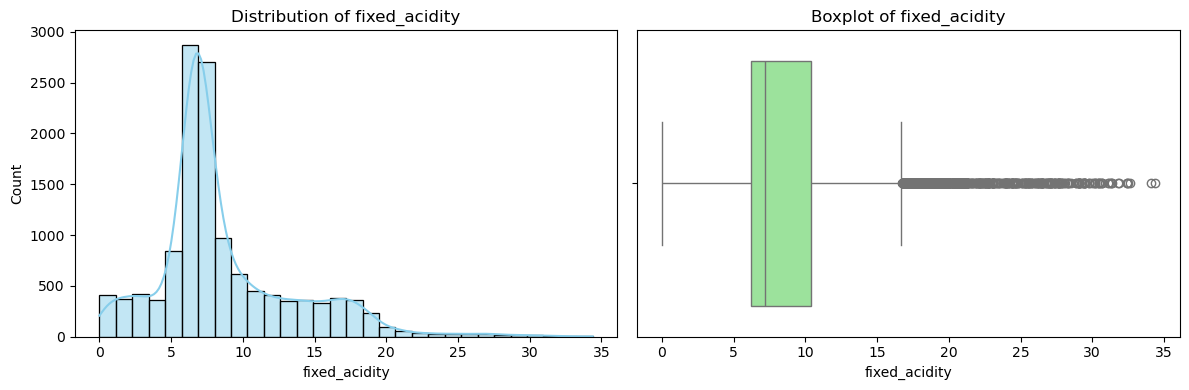

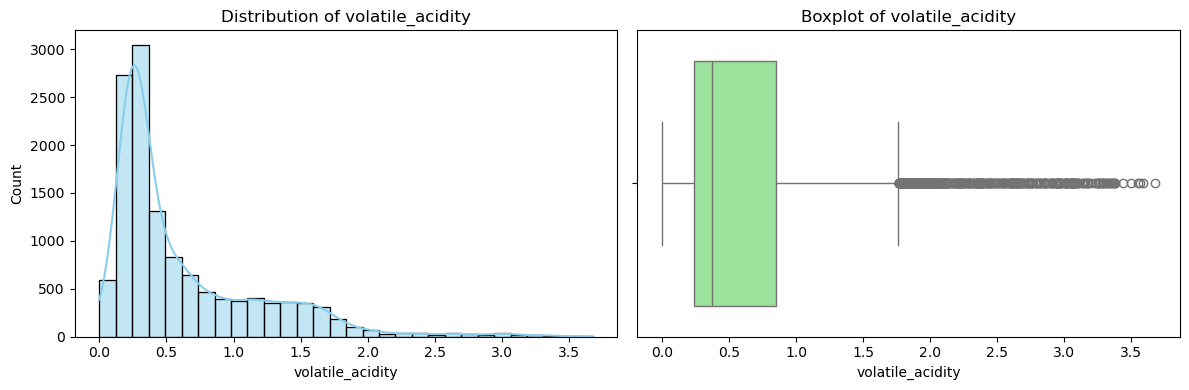

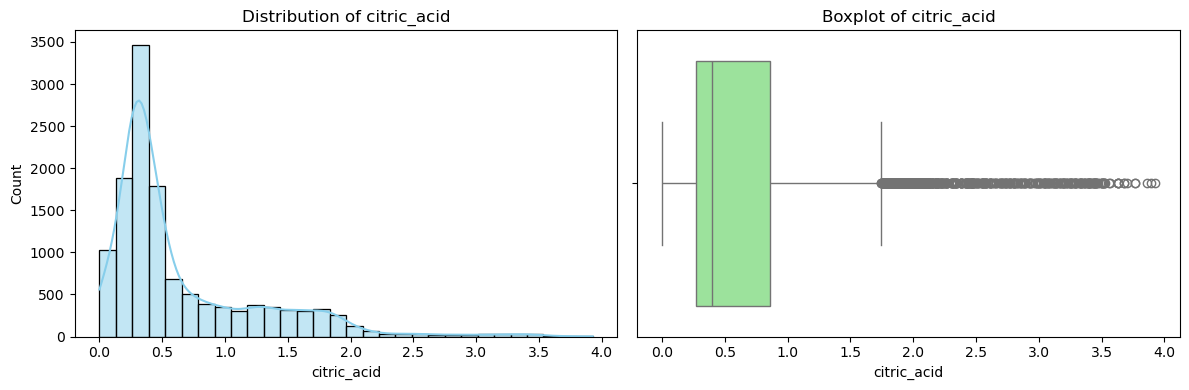

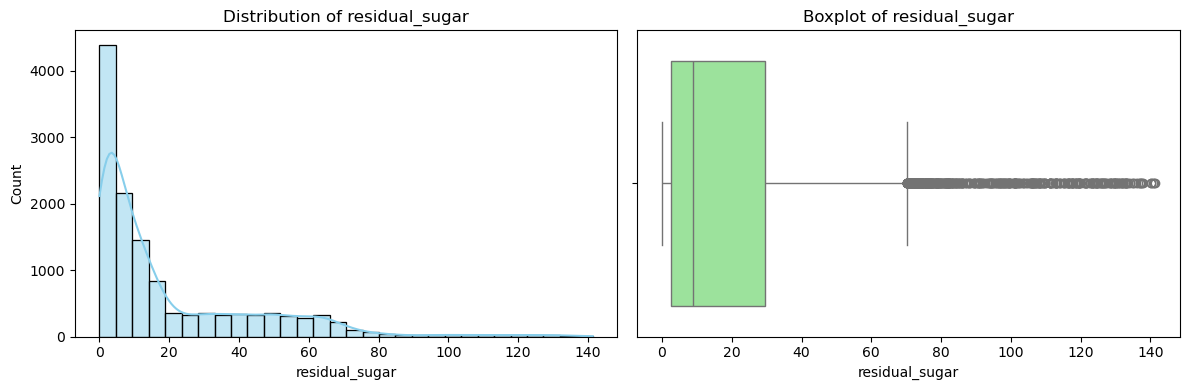

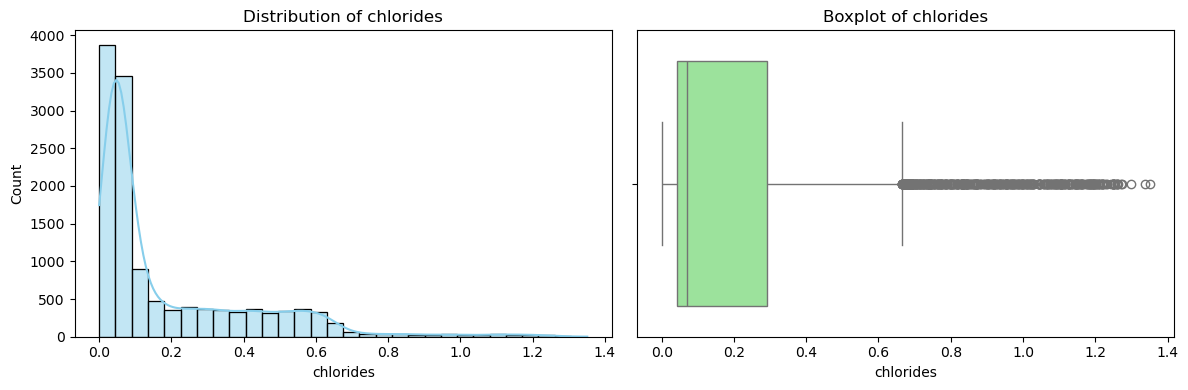

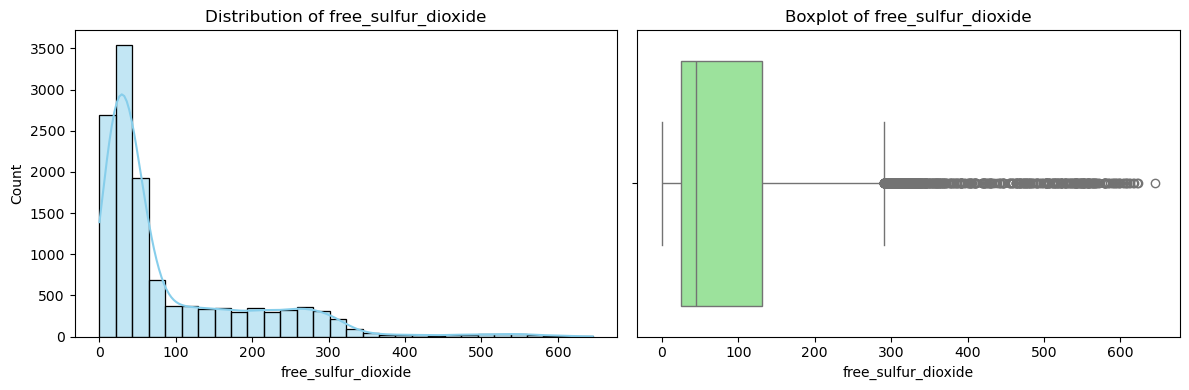

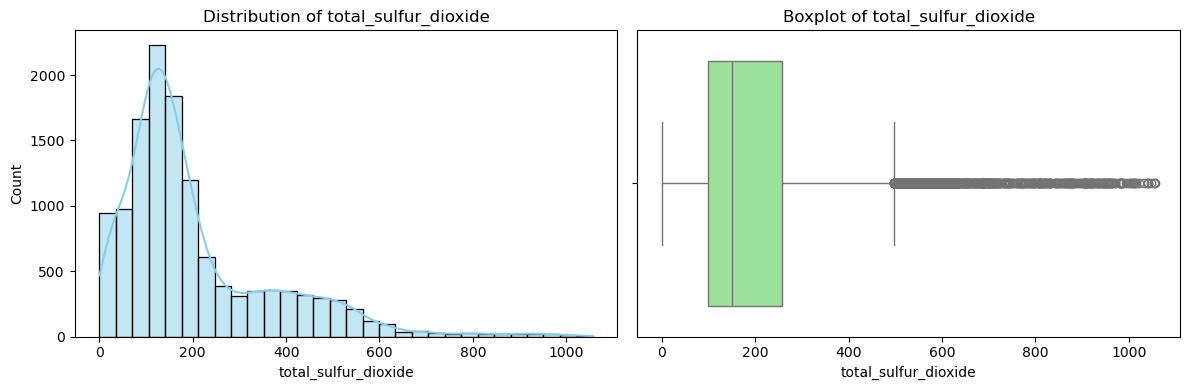

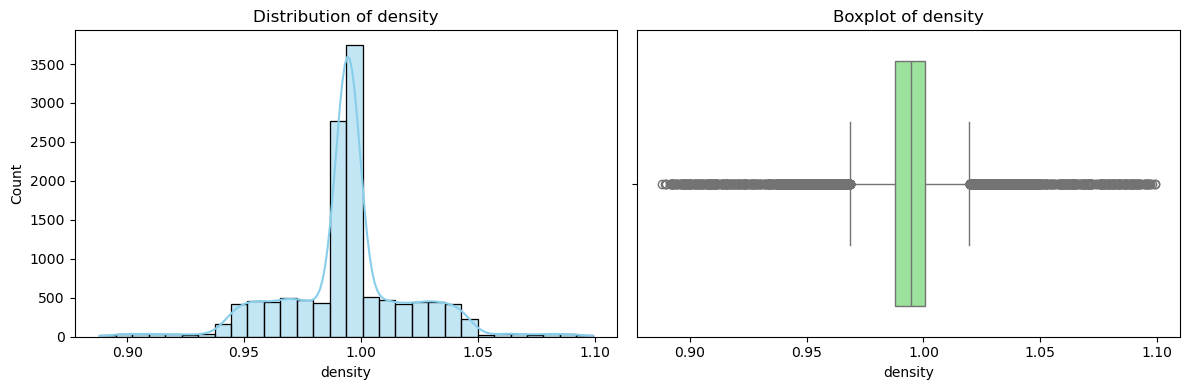

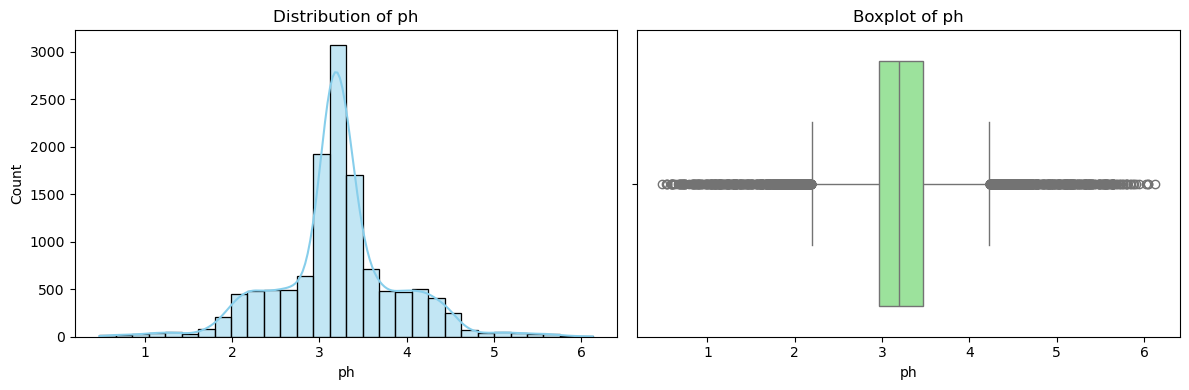

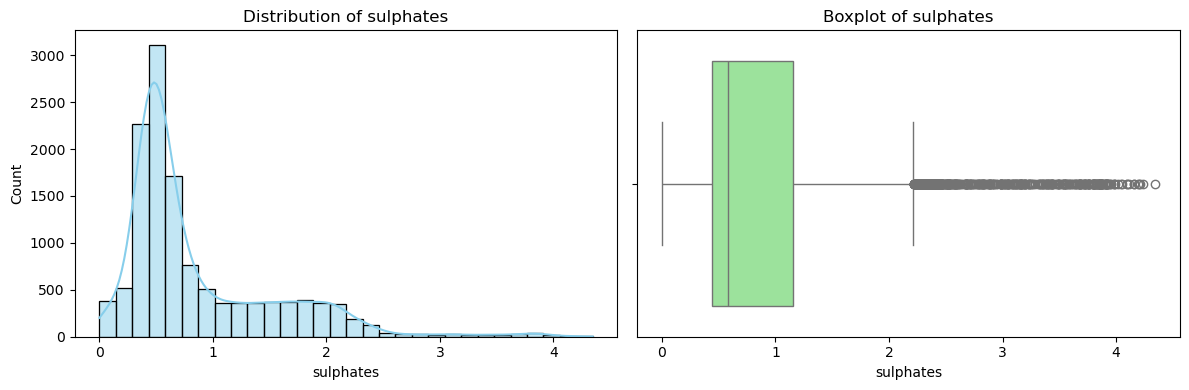

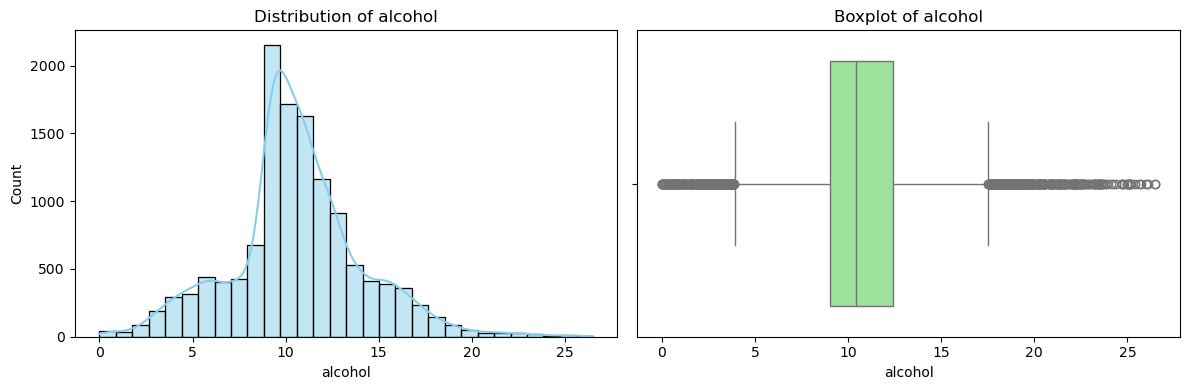

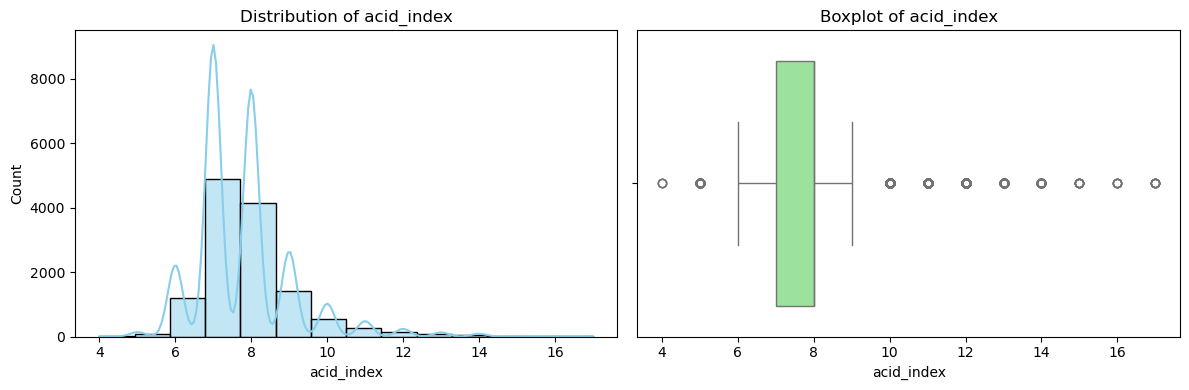

In [ ]:
# Histograms and boxplots for all numeric cols

# Get all numeric columns except 'target'
plot_cols = [c for c in num_cols if c not in ["target"]]

# Loop through each numeric column to create visualizations
for col in plot_cols:
    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Determine appropriate number of bins based on unique values
    # If fewer than 20 unique values, use that number as bins (for discrete-like data)
    # Otherwise use 30 bins (for continuous data)
    n_unique = df[col].nunique()
    bins = n_unique if n_unique < 20 else 30

    # Create histogram with kernel density estimate on the first subplot
    sns.histplot(df[col], bins=bins, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")

    # Create boxplot on the second subplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel(col)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Display the figure
    plt.show()

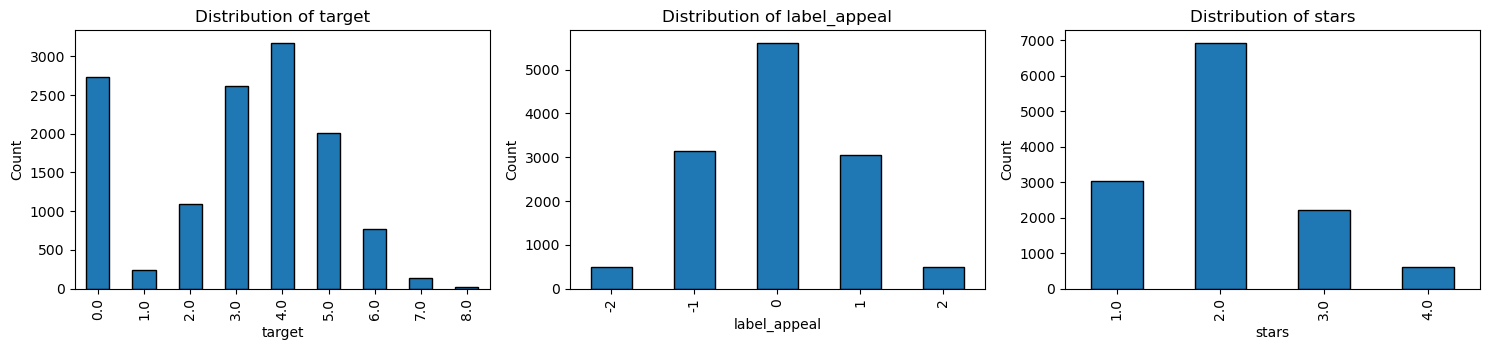

In [ ]:
# Categoricals: side-by-side bar charts
if cat_cols:
    # Find the maximum count across all categorical columns for consistent y-axis scaling
    max_count = max(df[c].value_counts().max() for c in cat_cols)

    # Create a figure with subplots - one for each categorical column
    fig, axes = plt.subplots(1, len(cat_cols), figsize=(5*len(cat_cols), 3.6))

    # If there's only one categorical column, wrap axes in a list for consistent iteration
    if len(cat_cols) == 1:
        axes = [axes]

    # Loop through each subplot and categorical column
    for ax, col in zip(axes, cat_cols):
        # Create a bar chart of value counts, sorted by index
        df[col].value_counts().sort_index().plot(kind="bar", ax=ax, edgecolor="black")

        # Set title and axis labels
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col); ax.set_ylabel("Count")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the figure
    plt.show()

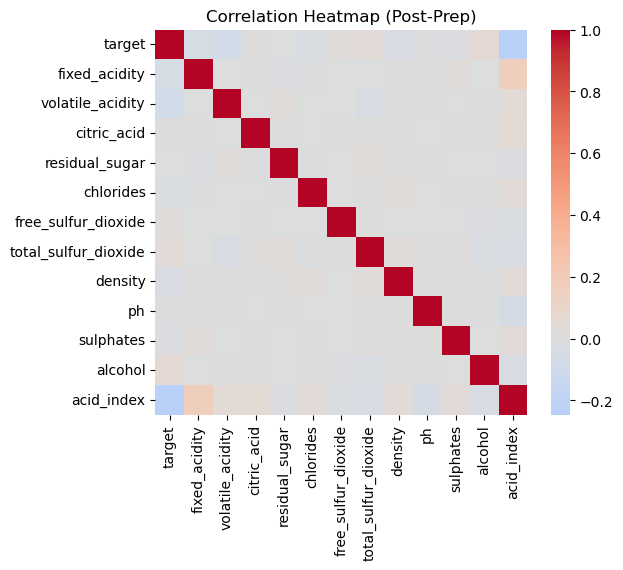

In [ ]:
def plot_correlation_heatmap(dataframe: pd.DataFrame,
                             numeric_columns: list,
                             figsize: tuple = (6, 5),
                             cmap: str = "coolwarm",
                             title: str = "Correlation Heatmap (Post-Prep)") -> None:
    # Check if we have at least 2 numeric columns to calculate correlation
    if len(numeric_columns) > 1:
        # Create a figure with specified dimensions
        plt.figure(figsize=figsize)
        # Calculate the correlation matrix for the selected numeric columns
        correlation_matrix = dataframe[numeric_columns].corr()
        # Create a heatmap visualization of the correlation matrix
        # center=0 ensures that the color scale is centered at 0
        sns.heatmap(correlation_matrix, cmap=cmap, center=0)
        # Add a title to the plot
        plt.title(title)
        # Display the plot
        plt.show()

# Usage
# Only create the heatmap if there are at least 2 numeric columns
if len(num_cols) > 1:
    plot_correlation_heatmap(df, num_cols)

#### Conclusions & Modeling Recommendations

After cleaning, all missing values were handled. For numeric columns, negative values (like alcohol or residual sugar) were treated as invalid and replaced with NaN, then imputed using Kernel Density Estimation (PDF sampling). This kept the distributions realistic and avoided flat imputation. For categorical features (target, label_appeal, stars), we used mode imputation to keep values valid.

The overall distributions of the variables stayed similar before and after prep, but many numeric features are still right-skewed with outliers (e.g., residual sugar, sulfur dioxide). These are expected in real wine data, so we kept them. Correlation analysis showed that most variables are independent, with the only noticeable relationship between acid_index and fixed_acidity. The target variable is imbalanced, meaning some sales categories dominate.

Recommendations:
Because of the skewness and outliers, we recommend using a tree-based model such as Random Forest or Gradient Boosting. These models can handle non-normal distributions and outliers without extra preprocessing. Logistic Regression can still be tried as a simple baseline, but it may struggle since the predictors are not normally distributed.